# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
train_data = pd.read_csv('train.csv')
train_data.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952


In [2]:
# 日期欄位在訓練及預測的時候用不到，可以先去除
train_data.drop(columns=['Date'], inplace=True)
train_data.head()

,Open Price,Close Price,High Price,Low Price,Volume
0,902.99,931.80,934.73,899.35,4048270080
1,929.17,927.45,936.63,919.53,5413910016
2,931.17,934.70,943.85,927.28,5392620032
3,927.45,906.65,927.45,902.37,4704940032
4,905.73,909.73,910.00,896.81,4991549952


In [3]:
# 根據今天和前一天的收盤價的差得到股價相較於昨天是漲還是跌
train_y = (train_data['Close Price'].diff(periods=1) > 0) * 1

# 漲跌要往前平移一天，因為是透過今天的股價和成交量去預測明天是漲還是跌
train_y = train_y[1:]
train_data = train_data[:-1]
print('size of train_X: {}, size of train_y: {}'.format(len(train_data), len(train_y)))

size of train_X: 2263, size of train_y: 2263


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_data)

# Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs').fit(train_data, train_y)
train_acc = clf.score(train_data, train_y)
print('Accuracy on training set: {}'.format(round(train_acc,4)))

Accuracy on training set: 0.5462


In [6]:
test_data = pd.read_csv('test.csv')
test_data.drop(columns=['Date'], inplace=True)
test_y = (test_data['Close Price'].diff(periods=1) > 0) * 1

# 一樣做往前一天的平移
test_y = test_y[1:]
test_data = test_data[:-1]
scaler = MinMaxScaler(feature_range=(0,1))
test_data = scaler.fit_transform(test_data)
print('size of test_X: {}, size of test_y: {}'.format(len(test_data), len(test_y)))

size of test_X: 251, size of test_y: 251


In [7]:
test_acc = clf.score(test_data, test_y)
print('Accuracy on testing set: {}'.format(round(test_acc,4)))

Accuracy on testing set: 0.5219


# Neural Network

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(128, input_dim=5))
model.add(Activation('tanh'))
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               768       
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_6 (Activation)    (None, 1)                

In [9]:
train_X = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))
test_X = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))

In [10]:
hist = model.fit(train_data, train_y,
          epochs=10, batch_size=128,
          validation_data=(test_data, test_y))


Train on 2263 samples, validate on 251 samples
Epoch 1/10
2263/2263 [==============================] - 0s 93us/step - loss: 0.6950 - accuracy: 0.5276 - val_loss: 0.6950 - val_accuracy: 0.5219
Epoch 2/10
2263/2263 [==============================] - 0s 17us/step - loss: 0.6894 - accuracy: 0.5413 - val_loss: 0.6996 - val_accuracy: 0.5219
Epoch 3/10
2263/2263 [==============================] - 0s 16us/step - loss: 0.6899 - accuracy: 0.5444 - val_loss: 0.6969 - val_accuracy: 0.5219
Epoch 4/10
2263/2263 [==============================] - 0s 16us/step - loss: 0.6892 - accuracy: 0.5493 - val_loss: 0.6975 - val_accuracy: 0.5219
Epoch 5/10
2263/2263 [==============================] - 0s 17us/step - loss: 0.6908 - accuracy: 0.5413 - val_loss: 0.6952 - val_accuracy: 0.5219
Epoch 6/10
2263/2263 [==============================] - 0s 15us/step - loss: 0.6893 - accuracy: 0.5444 - val_loss: 0.6990 - val_accuracy: 0.5219
Epoch 7/10
2263/2263 [==============================] - 0s 15us/step - loss: 0.689

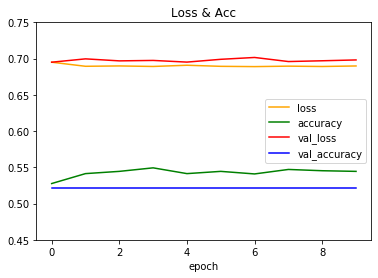

In [14]:
# 畫出 train 和 test 上 loss 及 accuracy 的變化
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='loss', color='orange')
plt.plot(hist.history['accuracy'], label='accuracy', color='green')
plt.plot(hist.history['val_loss'], label='val_loss', color='red')
plt.plot(hist.history['val_accuracy'], label='val_accuracy', color='blue')
plt.ylim(0.45,0.75)
plt.title('Loss & Acc')
plt.xlabel('epoch')
plt.legend()

In [12]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
rfc.fit(train_data, train_y)
train_acc = rfc.score(train_data, train_y)
print('Accuracy on training set: {}'.format(round(train_acc,4)))

Accuracy on training set: 0.5842


In [13]:
test_acc = rfc.score(test_data, test_y)
print('Accuracy on testing set: {}'.format(round(test_acc,4)))

Accuracy on testing set: 0.5697
